In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
plt.style.use('ggplot')
#import sncosmo
#import GPy
import subprocess
import pickle
import glob
import gzip

#import gp_sne

In [2]:
flux_norm = 1.0
time_norm = 1.0
position_norm = 1.0
grouping = 1

def SNPhotCC_Parser(filename):
    '''
    Reads and returns supernovae data into format to be read by the neural network. Replaces missing observation
    data with previous non-missing observation data - steps in data are present.
    * filename is a string containing the path to the supernovae light curve data
    * survey is a string containing the survey name
    * snid is an integer containing the supernova ID
    * ra is a float containing the RA of the supernova
    * dec is a float containing the Dec of the supernova
    * mwebv is a float describing the dust extinction
    * hostid is an integer containing the host galaxy ID
    * hostz is an array of floats containing the photometric redshift of the galaxy and the error on the measurement
    * spec is an array of floats containing the redshift
    * sim_type is a string containing the supernova type
    * sim_z is a float containing the redshift of the supernova
    * obs is a sequence of arrays each element containing [time since first observation,fluxes in each colourband,flux errors in each colourband]
    '''
    survey = snid = ra = dec = mwebv = hostid = hostz = spec = sim_type = sim_z = None
    #obs = []
    #g = r = i = z = 0
    #g_error = r_error = i_error = z_error = 0
    with gzip.open(filename, 'rb') as f:
        #first_obs = None
        for lineno,line in enumerate(f):
            s = line.split(':')
            if len(s) > 0:
                if s[0] == 'SURVEY':
                    survey = s[1].strip()
                elif s[0] == 'SNID':
                    snid = int(s[1].strip())
                elif s[0] == 'SNTYPE':
                    sn_type = int(s[1].strip())
                elif s[0] == 'RA':
                    ra = float(s[1].split('deg')[0].strip())/position_norm
                elif s[0] == 'DECL':
                    decl = float(s[1].split('deg')[0].strip())/position_norm
                elif s[0] == 'MWEBV':
                    mwebv = float(s[1].split('MW')[0].strip())
                elif s[0] == 'HOST_GALAXY_GALID':
                    hostid = int(s[1].strip())
                elif s[0] == 'HOST_GALAXY_PHOTO-Z':
                    hostz = float(s[1].split('+-')[0].strip()), float(s[1].split('+-')[1].strip())
                elif s[0] == 'REDSHIFT_SPEC':
                    spec = float(s[1].split('+-')[0].strip()), float(s[1].split('+-')[1].strip())
                elif s[0] == 'SIM_COMMENT':
                    sim_type = s[1].split('SN Type =')[1].split(',')[0].strip()
                elif s[0] == 'SIM_REDSHIFT':
                    sim_z = float(s[1])
                elif s[0] == 'VARLIST':
                    break
    obs = pd.read_table(gzip.GzipFile(filename), sep='\s+', header=0, skiprows=lineno, skipfooter=1, 
                        comment='DETECTION', engine='python',
                        usecols=[1,2,4,5,6,7,8,9])
    #obs = obs[obs.MAG < 99.]
    return survey, snid, sn_type, sim_type, sim_z, ra, decl, mwebv, hostid, hostz, spec, obs

## Example

In [4]:
N = 300
for n,f in enumerate(sorted(glob.glob('SIMGEN_PUBLIC_DES/DES_*.DAT.gz'))[:N]):
    survey, snid, sn_type, sim_type, sim_z, ra, decl, mwebv, hostid, hostz, spec, obs = SNPhotCC_Parser(f)
    print n, snid, sn_type, sim_type, sim_z, obs.shape
    if n == 60:  # stop at a nice big lightcurve
        break

obs.head()

0 17 -9 II 0.3972 (93, 8)
1 19 -9 II 0.9674 (60, 8)
2 126 -9 II 0.5621 (141, 8)
3 172 -9 II 0.4458 (115, 8)
4 303 -9 Ib 0.9024 (112, 8)
5 488 -9 II 0.7708 (145, 8)
6 556 -9 IIn 0.4532 (100, 8)
7 565 -9 II 0.7699 (161, 8)
8 642 -9 Ia 0.8128 (113, 8)
9 696 -9 IIL 0.3548 (133, 8)
10 742 -9 II 0.4541 (85, 8)
11 760 -9 Ib 0.8864 (51, 8)
12 762 -9 II 0.6733 (55, 8)
13 834 -9 Ib 0.3235 (47, 8)
14 858 -9 II 0.8275 (121, 8)
15 865 -9 II 0.5633 (106, 8)
16 873 -9 II 0.7469 (125, 8)
17 876 -9 Ib 0.2356 (40, 8)
18 903 -9 II 0.6655 (137, 8)
19 938 -9 Ia 0.7331 (120, 8)
20 967 -9 II 0.8998 (161, 8)
21 1024 -9 II 0.4091 (107, 8)
22 1049 -9 Ib 0.4459 (96, 8)
23 1056 -9 Ia 0.817 (41, 8)
24 1089 -9 IIn 0.7569 (55, 8)
25 1150 -9 II 0.9354 (108, 8)
26 1152 -9 II 0.5606 (48, 8)
27 1153 -9 Ia 0.8566 (145, 8)
28 1160 -9 IIn 0.8168 (44, 8)
29 1186 1 Ia 0.3698 (40, 8)
30 1253 -9 II 0.5786 (85, 8)
31 1292 22 II 0.3501 (90, 8)
32 1362 -9 II 0.6246 (120, 8)
33 1485 -9 II 0.6917 (52, 8)
34 1537 -9 Ib 0.3367 (47, 8

,MJD,FLT,FLUXCAL,FLUXCALERR,SNR,MAG,MAGERR,SIM_MAG
0,56176.191,g,6.955,4.773,1.46,25.394,1.260,24.853
1,56176.199,r,38.230,2.257,16.94,23.544,0.066,23.622
2,56176.215,i,36.530,3.225,11.33,23.593,0.100,23.662
3,56176.238,z,29.160,2.545,11.46,23.838,0.100,23.705
4,56179.188,g,21.060,2.635,8.00,24.191,0.145,24.350


In [5]:
filters = [b'g', b'r', b'i', b'z'] #, b'Y']
df = obs #sne_non1a[1].to_pandas()
for filt in filters:
    df = obs[obs.FLT == filt]
    x = df.MJD.values
    y = df.FLUXCAL.values
    dy = df.FLUXCALERR.values
    
print x
print y
print dy

[ 56176.238  56179.266  56180.328  56188.238  56189.312  56194.305
  56202.215  56210.234  56219.156  56221.324  56222.133  56228.109
  56229.102  56230.145  56231.102  56235.09   56236.105  56237.125
  56238.129  56243.152  56244.133  56245.137  56246.18   56247.34
  56258.066  56261.156  56273.219  56281.227  56288.141  56292.035]
[ 29.16   46.65   45.53   64.54   77.19   75.92   62.21   46.33   39.45
  15.6    26.2    28.65   40.58   27.79   31.79   40.82   24.08   26.35
  22.21   24.58   21.22   23.69   19.01   27.13   11.55   13.36    9.73
  12.99    7.943   7.881]
[  2.545   3.832   4.569   3.611   3.302   2.779   2.954   3.944   2.073
  14.4     5.082   4.171   4.909   2.718   3.334   8.268   5.34    3.73
   3.136   2.593   3.01    2.873   1.968   2.542   3.974   3.098   2.26
   2.305   2.589   2.068]


In [25]:
## see here: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gp_regression.html
from sklearn.gaussian_process import GaussianProcess
gp = GaussianProcess(corr='squared_exponential', regr='constant', normalize=False,
                     theta0=1e-1, thetaL=1e-3, thetaU=3., 
                     nugget=(dy / np.abs(y)) ** 2.,
                     random_start=100)

X = np.atleast_2d(x).T
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
XX = np.atleast_2d(np.linspace(x.min()-100., x.max()+100.)).T
y_pred, MSE = gp.predict(XX, eval_MSE=True)
sigma = np.sqrt(MSE)

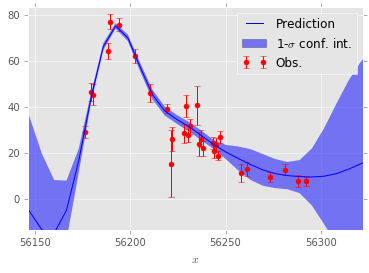

In [29]:
# Plot the function, the prediction and the 95% confidence interval based on the MSE
fig = plt.figure()
plt.errorbar(x, y, dy, fmt='r.', markersize=10, label=u'Obs.')
plt.plot(XX.ravel(), y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([XX, XX[::-1]]),
        #np.concatenate([y_pred - 1.9600 * sigma,
        #               (y_pred + 1.9600 * sigma)[::-1]]),
        np.concatenate([y_pred - sigma,
                       (y_pred + sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='1-$\sigma$ conf. int.')
plt.xlabel('$x$')
#plt.ylabel('$f(x)$')
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.xlim(x.min()-30, x.max()+30)
plt.legend(loc='upper right')

Try GPy instead. First, just emulate [this notebook](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/heteroscedastic_regression.ipynb).

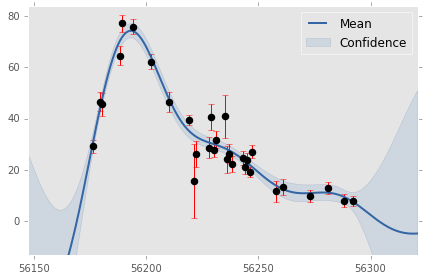

In [27]:
import GPy

#kern = GPy.kern.MLP(1) + GPy.kern.Bias(1)
#kern = GPy.kern.Linear(input_dim=1, variances=np.median(dy))
kern = GPy.kern.RBF(input_dim=1, variance=np.median(dy)*2., lengthscale=1.)
#kern = GPy.kern.Exponential(input_dim=1, variance=np.median(dy), lengthscale=1.)

m = GPy.models.GPHeteroscedasticRegression(x[:,None], y[:,None], kern)
m['.*het_Gauss.variance'] = np.abs(dy)[:,None] * 2. # Set the noise parameters to the error in Y
m.het_Gauss.variance.fix() # We can fix the noise term, since we already know it
#m.constrain_positive()
m.optimize()

m.plot_f() # Show the predictive values of the GP.
plt.errorbar(x, y, yerr=dy, fmt=None, ecolor='r', zorder=1)
plt.grid()
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.plot(x, y, 'ko', mew=1.5)

In [28]:
xfit = np.linspace(x.min()-30., x.max()+30., 100)
#print xfit
yfit = m.predict(xfit.T)

AssertionError: need at least column vectors as inputs to kernels for now, given X2.shape=(100,)

In [120]:
print type(m)
print m.input_dim
#?m.predict
??m.plot

<class 'GPy.models.gp_heteroscedastic_regression.GPHeteroscedasticRegression'>
1


In [36]:
new_lc, param, _ = gp_sne.preprocess_lc(lc, kernel='SE', debug=True)
tt = np.arange(-60, 120, step=2)
for i in range(0, 5):
    t, f, s = new_lc[i][:, 0], new_lc[i][:, 1], new_lc[i][:, 2]  
    tgp, fgp, sgp = gp_sne.gp_regression(t, f, s, xp=tt, kernel='SE', parameters=param[i, :], debug=True)

NameError: name 'gp_sne' is not defined

### Multiple realizations from MVN random generator

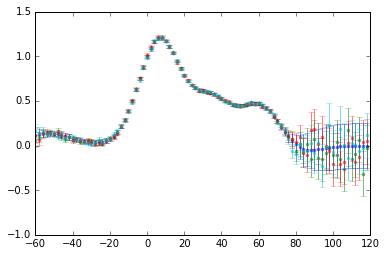

In [56]:
realizations = np.random.multivariate_normal(fgp, 0.25*np.diag(sgp**2), size=3)

plt.errorbar(tgp, fgp, sgp, fmt='.', alpha=0.5)
for i in range(3):
    plt.errorbar(tgp, realizations[i], sgp, fmt='.', alpha=0.5)

### Multiple realizations from the posterior

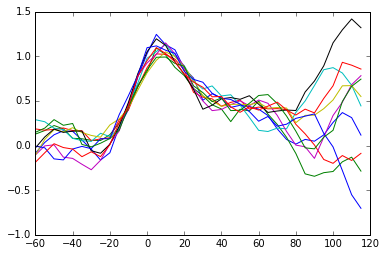

In [44]:
tt2 = np.arange(-60, 120, step=5)
kernel_gpy = GPy.kern.RBF(input_dim=1, variance=param[3, 0], lengthscale=param[3, 1]) 
kernel_gpy += GPy.kern.White(input_dim=1, variance=param[3, 2])
m = GPy.models.GPHeteroscedasticRegression(t[:, np.newaxis], f[:, np.newaxis] , kernel_gpy)
m['.*het_Gauss.variance'] = np.power(s[:, np.newaxis], 2.0)
posteriorTestY = m.posterior_samples_f(tt2[:, np.newaxis], full_cov=True, size=10)
plt.plot(tt2, posteriorTestY)

## Histogram of number of samples and pseudo SNR per band

In [343]:
NN = np.zeros(shape=(N, 2, 5))
SNR = np.zeros(shape=(N, 2, 5))
for i in range(0, N):
    df = sne_1a[i].to_pandas()
    lc=[]
    for j in range(5):
        lc.append(df[df.FLT == filters[j]][['MJD', 'FLUXCAL', 'FLUXCALERR']].values)
        NN[i, 0, j] = len(lc[-1])
        SNR[i, 0, j] = np.var(lc[-1][:, 1])/np.median(lc[-1][:, 2]**2)
        
    df = sne_non1a[i].to_pandas()
    lc=[]
    for j in range(5):
        lc.append(df[df.FLT == filters[j]][['MJD', 'FLUXCAL', 'FLUXCALERR']].values)
        NN[i, 1, j] = len(lc[-1])
        SNR[i, 1, j] = np.var(lc[-1][:, 1])/np.median(lc[-1][:, 2]**2)

 /usr/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning:Degrees of freedom <= 0 for slice
 /usr/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning:Mean of empty slice.


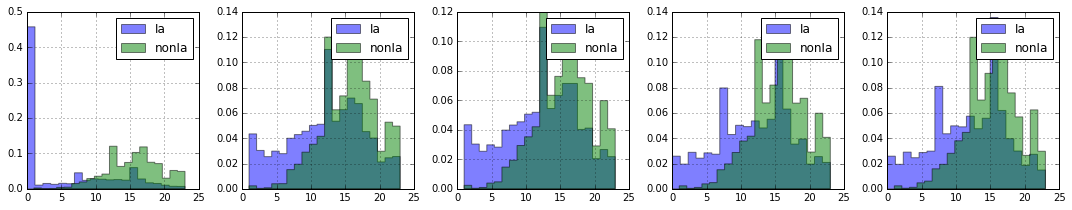

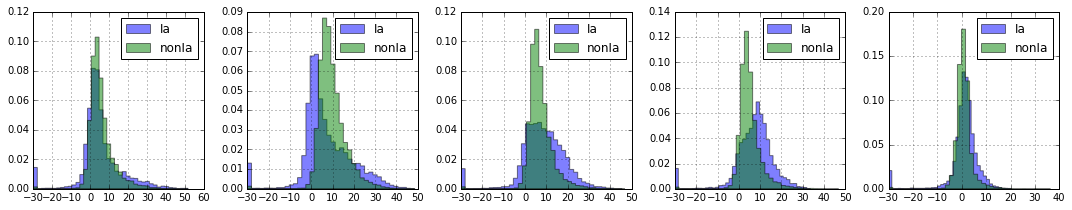

In [356]:
fig = plt.figure(figsize=(15, 3))
for j in range(5):
    ax = fig.add_subplot(1, 5, j+1)
    _ = ax.hist(NN[:, 0, j], 20, label='Ia', normed=True, histtype='stepfilled', alpha=0.5)
    _ = ax.hist(NN[:, 1, j], 20, label='nonIa', normed=True, histtype='stepfilled', alpha=0.5)
    plt.legend()
    plt.grid()
plt.tight_layout()

fig = plt.figure(figsize=(15, 3))
for j in range(5):
    ax = fig.add_subplot(1, 5, j+1)
    _ = ax.hist(10*np.log10(0.001+SNR[~np.isnan(SNR[:, 0, j]), 0, j]), 40, label='Ia', normed=True, histtype='stepfilled', alpha=0.5)
    _ = ax.hist(10*np.log10(0.001+SNR[~np.isnan(SNR[:, 1, j]), 1, j]), 40, label='nonIa', normed=True, histtype='stepfilled', alpha=0.5)
    plt.legend()
    plt.grid()
plt.tight_layout()

## Get features from LEFTRARU

The features were computed using the procedure shown above with the example

In [258]:
cmd = """rsync -avz -e "ssh -i ~/.ssh/phuijse_leftraru" phuijse@leftraru.nlhpc.cl:RESULTS/features_lsst_ddf_* . """ 
print("rsyncing...")
res = subprocess.call(cmd, shell=True)
if res == 0:
    print("Success!")

rsyncing...
Success!


In [4]:
features, Np = pickle.load(open("features_lsst_ddf_30000.p", "rb"))

## Normalization

In [5]:
mask = np.amin(Np, axis=1) > 5
print("Remaining lc after masking: %d "% (len(np.where(mask == True)[0])))

tt = np.arange(-60, 120, step=2)

Nlc, m1, m2, m3 = features.shape
data = np.reshape(features, (Nlc, m1*m2*m3))
#data = np.reshape(features[:, 0, :, :], (Nlc, m2*m3))
data = data[mask]

labels = np.zeros(shape=(Nlc,))
labels[int(0.5*Nlc):] = 1.0
labels = labels[mask]

print("Class 1: %d" %(len(labels[labels==0])))
print("Class 2: %d" %(len(labels[labels==1])))

m = int(0.5*m1*m2*m3)
for i in range(0, m):
    mu = np.mean(data[:, i])
    std = np.std(data[:, i])
    data[:, i] = (data[:, i] - mu)/std
    data[:, i+m] = np.sqrt((data[:, i+m]))/std

Remaining lc after masking: 42102 
Class 1: 12381
Class 2: 29721


## Classification and evaluation

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.cross_validation import StratifiedShuffleSplit, ShuffleSplit
import time

folds = 5
W = 3  # FoM SNPCC
cm = np.zeros(shape=(2, 2, folds))
roc_fpr = np.logspace(-2.0, 0.0, num=30)
roc_tpr = np.zeros(shape=(folds, len(roc_fpr)))
roc_precision = np.linspace(0.0, 1.0, num=60)
roc_recall = np.zeros(shape=(folds, len(roc_precision))) 
Ntrain = int(0.1*len(labels))
print("Training with %d samples" %(Ntrain))
metrics = np.zeros(shape=(folds, 5)) #Precision, Efficiency/Recall/TPR, FP rate, FoM for Ia vs non-Ia

sss = StratifiedShuffleSplit(labels, n_iter=folds, test_size=None, train_size=Ntrain)
#sss = ShuffleSplit(data.shape[0], n_iter=folds, test_size=None, train_size=Ntrain)
#rf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', class_weight='balanced_subsample',
#                            n_jobs=4, criterion='entropy')
rf = GradientBoostingClassifier(loss='deviance', n_estimators=1000, max_features='sqrt',
                                learning_rate=0.05, presort=True)

for i, (train_index, test_index) in enumerate(sss):
    tic = time.time()
    rf.fit(data[train_index, :], labels[train_index])
    label_pred = rf.predict_proba(data[test_index, :])
    
    fpr, tpr, thresholds = roc_curve(labels[test_index], label_pred[:, 0], pos_label=0)        
    roc_tpr[i, :] = np.interp(roc_fpr, fpr, tpr)
    fpr, tpr, thresholds = precision_recall_curve(labels[test_index], label_pred[:, 0], pos_label=0)
    roc_recall[i, :] = np.interp(roc_precision, fpr, tpr)
    cm[:, :, i] = confusion_matrix(labels[test_index], rf.predict(data[test_index, :]))
    
    TP = cm[0, 0, i]
    FP = cm[1, 0, i]
    FN = cm[0, 1, i]
    TN = cm[1, 1, i]
    metrics[i, 0] = TP/(TP+FP)
    metrics[i, 1] = TP/(TP+FN)
    metrics[i, 2] = FP/(FP+TN)
    metrics[i, 3] = 2*metrics[i, 0]*metrics[i, 1]/(metrics[i, 0] + metrics[i, 1])
    metrics[i, 4] = TP**2/((TP + W*FP)*(TP+FN))
    print(" %d Elapsed time [s]: %f" % (i, time.time() - tic))

Training with 4210 samples
 0 Elapsed time [s]: 23.053351
 1 Elapsed time [s]: 20.725604
 2 Elapsed time [s]: 19.519948
 3 Elapsed time [s]: 19.843956
 4 Elapsed time [s]: 19.483636


[[ 10639.6    503.4]
 [   579.   26170. ]]
Results Ia vs not Ia
Precision:	 0.948399 +- 0.002623
Recall:		 0.954824 +- 0.001852
FPR:		 0.021646 +- 0.001177
F1:		 0.951597 +- 0.001216
FoM:		 0.820865 +- 0.005635


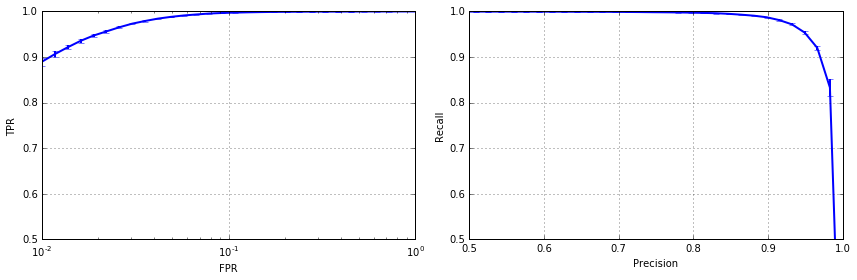

In [7]:
print(np.average(cm, axis=2))
print("Results Ia vs not Ia")
print("Precision:\t %f +- %f" %(np.mean(metrics[:, 0]), np.std(metrics[:, 0])))
print("Recall:\t\t %f +- %f" %(np.mean(metrics[:, 1]), np.std(metrics[:, 1])))
print("FPR:\t\t %f +- %f" %(np.mean(metrics[:, 2]), np.std(metrics[:, 2])))
print("F1:\t\t %f +- %f" %(np.mean(metrics[:, 3]), np.std(metrics[:, 3])))
print("FoM:\t\t %f +- %f" %(np.mean(metrics[:, 4]), np.std(metrics[:, 4])))


fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)

   
ax.errorbar(roc_fpr, np.average(roc_tpr, axis=0), np.std(roc_tpr, axis=0), linewidth=2)
plt.tight_layout()
ax.set_xlim([0.01, 1.0])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
ax.errorbar(roc_precision, np.average(roc_recall, axis=0), np.std(roc_recall, axis=0), linewidth=2)
plt.tight_layout()
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.0])
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
plt.grid()


plt.tight_layout()

## Feature importance

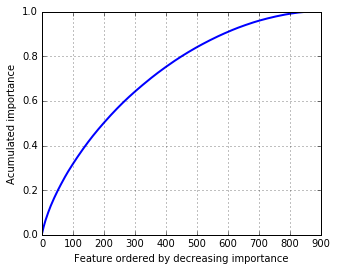

In [8]:
plt.figure(figsize=(5,4))
plt.plot(np.cumsum(np.sort(rf.feature_importances_)[::-1]), linewidth=2)
plt.xlabel('Feature ordered by decreasing importance')
plt.ylabel('Acumulated importance')
plt.grid()

### Importance per channel

Features related to flux: 48.0 %
Features related to eflux: 52.0 %


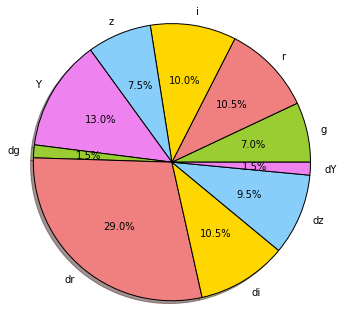

In [12]:
imp = rf.feature_importances_
idx = np.argsort(imp)[::-1][:200] # First 200 features

Nf = 90
nbands=5
Npc = np.zeros(shape=(nbands, 2))
filters=['g','r','i','z','Y', 
         'dg','dr','di','dz', 'dY']
#filters=['g','r','i','z','Y']
colors=['yellowgreen', 'lightcoral', 'gold', 'lightskyblue', 'violet',
        'yellowgreen', 'lightcoral', 'gold', 'lightskyblue', 'violet']

for i in range(nbands):
    Npc[i, 0] = len(np.where((idx >= i*Nf) & (idx < (i+1)*Nf))[0])
    Npc[i, 1] = len(np.where((idx >= Nf*nbands + i*Nf) & (idx < Nf*nbands + (i+1)*Nf))[0])

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.pie(Npc.T.ravel(), labels=filters, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=0)
ax.axis('equal')


print("Features related to flux: %0.1f %%" %(100*np.sum(Npc[:, 0])/200))
print("Features related to eflux: %0.1f %%" %(100*np.sum(Npc[:, 1])/200))

### Uncertainty feature distributed among classes

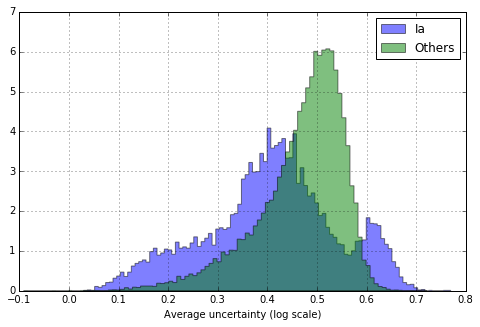

In [13]:
plt.figure(figsize=(8, 5))
_ = plt.hist(np.log10(np.mean(data[labels==0][:, Nf*nbands:2*Nf*nbands], axis=1)), 
             100, histtype='stepfilled', alpha=0.5, normed=True, label='Ia')
_ = plt.hist(np.log10(np.mean(data[labels==1][:, Nf*nbands:2*Nf*nbands], axis=1)), 
             100, histtype='stepfilled', alpha=0.5, normed=True, label='Others')
plt.legend()
plt.grid()
plt.xlabel('Average uncertainty (log scale)')

### Importance in time

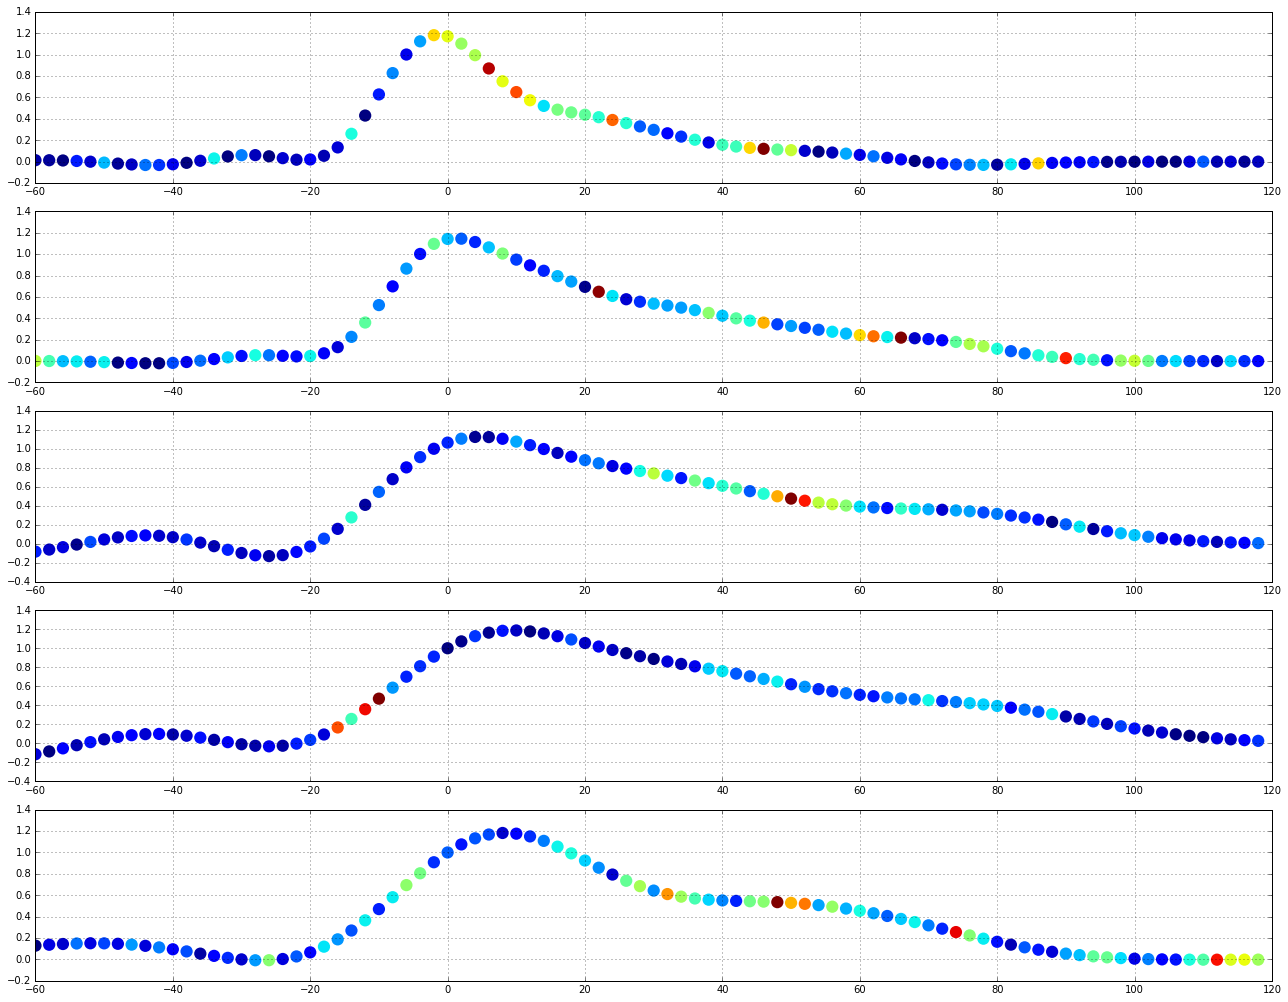

In [14]:
fig = plt.figure(figsize=(18, 14))
d = int(0.5*Nlc) + 1

for band in range(0, nbands):
    ax = fig.add_subplot(nbands, 1, band+1)
    color = imp[band*Nf:(band+1)*Nf]
    color = (color - np.amin(color))/(np.amax(color) - np.amin(color))
    ax.scatter(tt, features[d, 0, band, :], c=color, s=150, linewidth=0, cmap=plt.get_cmap('jet'))
    plt.grid()
    plt.xlim(-60, 120)
plt.tight_layout()